In [38]:
import pandas as pd
import numpy as np
import os
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import RobustScaler
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import ipywidgets as widgets
from IPython.display import display
from imblearn.over_sampling import SMOTE

# Set plotting style
%matplotlib inline
plt.style.use('ggplot')
sns.set_palette('Blues')

# Print working directory and files
print("Current working directory:", os.getcwd())
print("Files in directory:", os.listdir('.'))

Current working directory: c:\Users\khale\OneDrive\Desktop\dataset
Files in directory: ['.git', 'assignments.csv', 'assignment_submissions.csv', 'attendances.csv', 'courses (1).csv', 'enrollments.csv', 'grades.csv', 'logistic_model.pkl', 'predictions.csv', 'search_results_10.csv', 'search_results_11.csv', 'search_results_9.csv', 'Student_Pass_Fail_Predict copy.ipynb', 'users (2).csv']


C:\Users\khale\AppData\Local\Temp\ipykernel_37592\3554003409.py:38: DeprecationWarning:

DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.



Data shape: (468, 5)
Target distribution: status
0    0.559829
1    0.440171
Name: proportion, dtype: float64
Missing values in features:
 attendance_percentage     0
assignments               0
midterm                   0
avg_grade                 0
attendance_consistency    0
dtype: int64
Feature data types:
 attendance_percentage     float64
assignments                 int64
midterm                     int64
avg_grade                 float64
attendance_consistency    float64
dtype: object
Feature ranges:
        attendance_percentage  assignments     midterm   avg_grade  \
count             468.000000   468.000000  468.000000  468.000000   
mean               13.165118    11.532051   15.128205   13.330128   
std                12.286510     6.053035    8.913612    5.417425   
min                 3.571429     0.000000    0.000000    0.000000   
25%                 6.250000     7.000000    8.000000    9.000000   
50%                 7.812500    11.000000   15.000000   13.500000   
75%

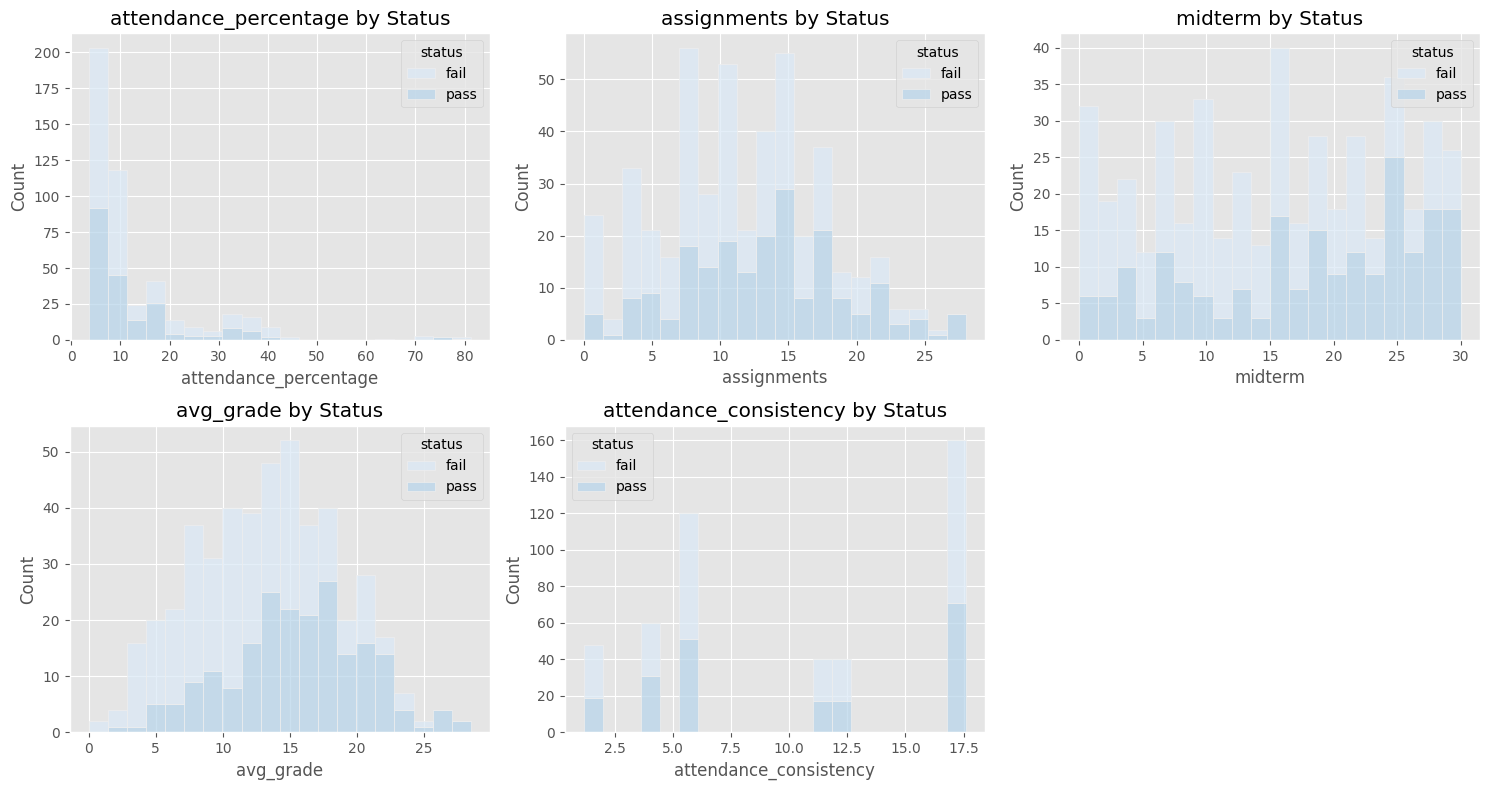

In [39]:
# Function to load CSV with error handling
def load_csv(file_path):
    try:
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File {file_path} not found. Please check the file path.")
        return pd.read_csv(file_path)
    except FileNotFoundError as e:
        print(e)
        return None
    except Exception as e:
        print(f"Error loading {file_path}: {e}")
        return None

# Load data
grades = load_csv('grades.csv')
attendances = load_csv('attendances.csv')

# Initialize variables
data = None
X = None
y = None
scaler = None
feature_names = ['attendance_percentage', 'assignments', 'midterm', 'avg_grade', 'attendance_consistency']

if grades is not None and attendances is not None:
    # Validate columns
    required_grade_cols = ['student_id', 'course_id', 'assignments', 'midterm', 'status']
    required_attendance_cols = ['student_id', 'course_id', 'date', 'type', 'status']
    if not all(col in grades.columns for col in required_grade_cols):
        print("Missing columns in grades.csv:", [col for col in required_grade_cols if col not in grades.columns])
        grades = None
    if not all(col in attendances.columns for col in required_attendance_cols):
        print("Missing columns in attendances.csv:", [col for col in required_attendance_cols if col not in attendances.columns])
        attendances = None

if grades is not None and attendances is not None:
    # Calculate total sessions per course
    total_sessions = attendances.groupby('course_id').apply(
        lambda x: x[['date', 'type']].drop_duplicates().shape[0]
    ).reset_index(name='total_sessions')

    # Calculate present count per student per course
    present_count = attendances[attendances['status'] == 'present'].groupby(
        ['student_id', 'course_id']
    ).size().reset_index(name='present_count')

    # Merge data
    data = pd.merge(grades, present_count, on=['student_id', 'course_id'], how='left')
    data = pd.merge(data, total_sessions, on='course_id', how='left')

    # Calculate attendance percentage
    data['attendance_percentage'] = (data['present_count'] / data['total_sessions']) * 100

    # Clean data: ensure valid ranges
    data['assignments'] = pd.to_numeric(data['assignments'], errors='coerce').clip(0, 100)
    data['midterm'] = pd.to_numeric(data['midterm'], errors='coerce').clip(0, 100)
    data['attendance_percentage'] = data['attendance_percentage'].clip(0, 100)

    # Handle missing values
    data['present_count'] = data['present_count'].fillna(0)
    data['attendance_percentage'] = data['attendance_percentage'].fillna(0)
    data['assignments'] = data['assignments'].fillna(data['assignments'].median())
    data['midterm'] = data['midterm'].fillna(data['midterm'].median())

    # Feature engineering
    data['avg_grade'] = (data['assignments'] + data['midterm']) / 2
    data['attendance_consistency'] = data.groupby('student_id')['attendance_percentage'].transform('std').fillna(0)

    # Validate status labels
    data['status'] = data['status'].str.lower()
    invalid_status = data[~data['status'].isin(['pass', 'fail'])]['status'].unique()
    if len(invalid_status) > 0:
        print("Invalid status values found:", invalid_status)
    data = data[data['status'].isin(['pass', 'fail'])]
    suspicious_fails = data[(data['status'] == 'fail') & (data['midterm'] > 80) & (data['assignments'] > 80)]
    if not suspicious_fails.empty:
        print("Suspicious fails (high scores):", suspicious_fails[['student_id', 'course_id', 'midterm', 'assignments', 'status']])

    # Drop rows with missing status
    data = data.dropna(subset=['status'])

    # Select features and target
    X = data[feature_names]
    y = data['status'].map({'pass': 1, 'fail': 0})

    # Diagnostics
    print("Data shape:", X.shape)
    print("Target distribution:", y.value_counts(normalize=True))
    print("Missing values in features:\n", X.isnull().sum())
    print("Feature data types:\n", X.dtypes)
    print("Feature ranges:\n", X.describe())

    # Visualize feature distributions by class
    plt.figure(figsize=(15, 8))
    for i, feature in enumerate(feature_names, 1):
        plt.subplot(2, 3, i)
        sns.histplot(data=data, x=feature, hue='status', multiple='stack', bins=20)
        plt.title(f'{feature} by Status')
    plt.tight_layout()
    plt.show()
else:
    print("Data loading failed. Please check CSV files.")

In [40]:
model = None
threshold = 0.6  # Starting threshold
if grades is not None and attendances is not None and X is not None and y is not None:
    # Scale features
    scaler = RobustScaler()
    X_scaled = scaler.fit_transform(X)

    # Split data
    X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)

    # Apply SMOTE with aggressive oversampling
    smote = SMOTE(sampling_strategy=1.0, random_state=42)  # Equal Fail and Pass
    X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)
    print("Balanced training set distribution:", pd.Series(y_train_balanced).value_counts(normalize=True))

    # Parameter tuning with GridSearchCV
    param_grid = {
        'C': [0.001, 0.01, 0.1, 1, 10, 100],
        'solver': ['lbfgs', 'liblinear'],
        'class_weight': ['balanced', None]
    }
    grid = GridSearchCV(LogisticRegression(max_iter=5000), param_grid, cv=5, scoring='f1_macro', n_jobs=-1)
    grid.fit(X_train_balanced, y_train_balanced)

    # Best model
    model = grid.best_estimator_
    print("Best parameters:", grid.best_params_)
    print("Best cross-validation F1-score:", grid.best_score_)

    # Threshold optimization
    y_prob = model.predict_proba(X_test)[:, 1]
    thresholds = np.arange(0.5, 0.71, 0.05)  # Narrowed range
    best_threshold = threshold
    best_f1 = 0
    print("\nThreshold optimization results:")
    for t in thresholds:
        y_pred_t = (y_prob >= t).astype(int)
        num_fails = np.sum(y_pred_t == 0)
        report = classification_report(y_test, y_pred_t, output_dict=True, zero_division=0)
        f1 = report['0']['f1-score']
        print(f"Threshold={t:.2f}, Fail predictions={num_fails}, Fail F1-score={f1:.3f}")
        if f1 > best_f1:
            best_f1 = f1
            best_threshold = t
    print(f"\nOptimal threshold for Fail F1-score: {best_threshold:.2f}")
    threshold = best_threshold

    # Evaluate on test set with optimal threshold
    y_pred = (y_prob >= threshold).astype(int)
    accuracy = accuracy_score(y_test, y_pred)
    print(f"\nTest Accuracy (threshold={threshold}): {accuracy:.3f}")
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, target_names=['Fail', 'Pass'], zero_division=0))

    # Analyze borderline cases
    print("\nBorderline predictions (probability between 0.4 and 0.6):")
    borderline_mask = (y_prob >= 0.4) & (y_prob <= 0.6)
    borderline_idx = np.where(borderline_mask)[0]
    if len(borderline_idx) > 0:
        test_indices = y_test.index[borderline_idx]
        borderline_data = data.loc[test_indices][['student_id', 'course_id', 'attendance_percentage', 'assignments', 'midterm', 'avg_grade', 'attendance_consistency', 'status']]
        borderline_data['Predicted'] = ['Pass' if p >= threshold else 'Fail' for p in y_prob[borderline_idx]]
        borderline_data['Probability'] = y_prob[borderline_idx]
        print(borderline_data)
    else:
        print("No borderline cases found.")
else:
    print("Cannot train model due to data loading issues.")

Balanced training set distribution: status
1    0.5
0    0.5
Name: proportion, dtype: float64
Best parameters: {'C': 0.01, 'class_weight': None, 'solver': 'lbfgs'}
Best cross-validation F1-score: 0.6440931074081042

Threshold optimization results:
Threshold=0.50, Fail predictions=43, Fail F1-score=0.714
Threshold=0.55, Fail predictions=65, Fail F1-score=0.800
Threshold=0.60, Fail predictions=86, Fail F1-score=0.780
Threshold=0.65, Fail predictions=92, Fail F1-score=0.748
Threshold=0.70, Fail predictions=93, Fail F1-score=0.743

Optimal threshold for Fail F1-score: 0.55

Test Accuracy (threshold=0.55): 0.745

Classification Report:
              precision    recall  f1-score   support

        Fail       0.74      0.87      0.80        55
        Pass       0.76      0.56      0.65        39

    accuracy                           0.74        94
   macro avg       0.75      0.72      0.72        94
weighted avg       0.75      0.74      0.74        94


Borderline predictions (probabili

In [41]:
if grades is not None and attendances is not None and model is not None:
    # Interactive Confusion Matrix
    cm = confusion_matrix(y_test, y_pred)
    fig = px.imshow(
        cm, text_auto=True, color_continuous_scale='Blues',
        x=['Fail', 'Pass'], y=['Fail', 'Pass'],
        labels={'x': 'Predicted', 'y': 'Actual'},
        title=f'Confusion Matrix (Threshold={threshold})'
    )
    fig.update_layout(width=600, height=600)
    fig.show()

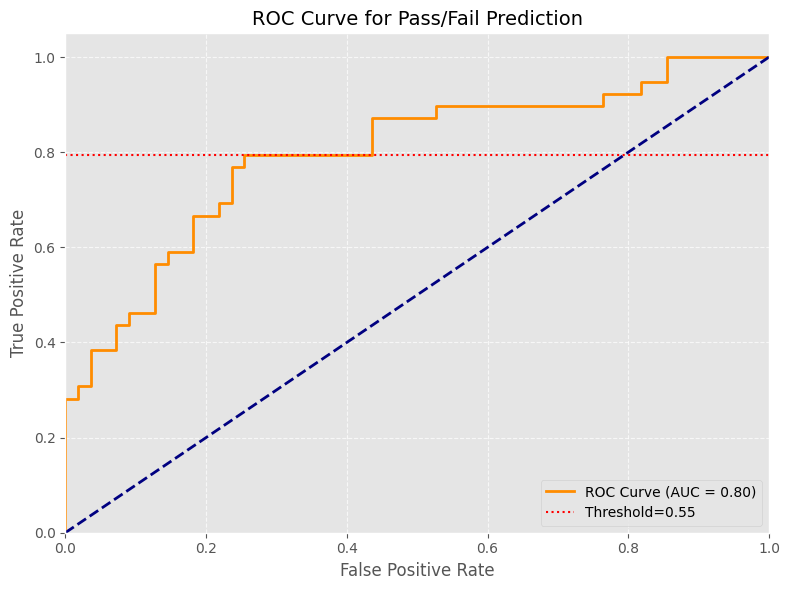

In [42]:
if grades is not None and attendances is not None and model is not None:
    # ROC Curve
    y_prob = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)

    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC Curve (AUC = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.axhline(y=tpr[np.argmin(np.abs(fpr - (1 - threshold)))], color='red', linestyle=':', label=f'Threshold={threshold}')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate', fontsize=12)
    plt.ylabel('True Positive Rate', fontsize=12)
    plt.title('ROC Curve for Pass/Fail Prediction', fontsize=14)
    plt.legend(loc='lower right')
    plt.grid(True, linestyle='--', alpha=0.7)
    plt.tight_layout()
    plt.show()

In [43]:
if grades is not None and attendances is not None and model is not None:
    # Feature Importance Bar Plot
    coef_df = pd.DataFrame({
        'Feature': feature_names,
        'Coefficient': model.coef_[0]
    })
    fig = px.bar(coef_df, x='Feature', y='Coefficient', color='Coefficient',
                 color_continuous_scale='RdBu', height=500,
                 title='Feature Importance in Pass/Fail Prediction')
    fig.update_layout(xaxis_title='Feature', yaxis_title='Coefficient Value',
                     showlegend=False, template='plotly_white')
    fig.show()

In [44]:
if grades is not None and attendances is not None and model is not None:
    # Save model
    import joblib
    joblib.dump(model, 'logistic_model.pkl')
    print("Model saved as logistic_model.pkl")

    # Save predictions
    pd.DataFrame({'Actual': y_test, 'Predicted': y_pred}).to_csv('predictions.csv')
    print("Predictions saved as predictions.csv")

Model saved as logistic_model.pkl
Predictions saved as predictions.csv


In [45]:
if grades is not None and attendances is not None and model is not None and data is not None and scaler is not None:
    def search_student(student_id):
        # Filter student data
        student_data = data[data['student_id'] == student_id]
        
        if student_data.empty:
            print(f"No data found for student ID {student_id}")
            print("Valid student IDs:", data['student_id'].unique()[:10], "...")
            return
        
        # Display details
        print(f"\nStudent ID: {student_id}")
        for _, row in student_data.iterrows():
            print(f"Course ID: {row['course_id']}")
            print(f"  Assignment Score: {row['assignments']:.2f}")
            print(f"  Midterm Score: {row['midterm']:.2f}")
            print(f"  Attendance %: {row['attendance_percentage']:.2f}%")
            print(f"  Actual Status: {row['status']}")

            # Predict pass/fail with custom threshold
            features = pd.DataFrame(
                [[row['attendance_percentage'], row['assignments'], row['midterm'], row['avg_grade'], row['attendance_consistency']]],
                columns=feature_names
            )
            features_scaled = scaler.transform(features)
            prob = model.predict_proba(features_scaled)[0][1]
            prediction = 1 if prob >= threshold else 0
            print(f"  Predicted Status: {'Pass' if prediction == 1 else 'Fail'} (Probability of Pass: {prob:.2%})")
            if prediction != (1 if row['status'] == 'pass' else 0):
                print("  WARNING: Prediction does not match actual status!")
        
        # Export search results
        search_results = student_data[['student_id', 'course_id', 'assignments', 'midterm', 'attendance_percentage', 'status']].copy()
        search_results['predicted_status'] = ['Pass' if p >= threshold else 'Fail' for p in model.predict_proba(scaler.transform(student_data[feature_names]))[:, 1]]
        search_results['pass_probability'] = model.predict_proba(scaler.transform(student_data[feature_names]))[:, 1]
        search_results.to_csv(f'search_results_{student_id}.csv', index=False)
        print(f"Search results saved to search_results_{student_id}.csv")
        print(f"\nNote: Predictions are based on the trained model with threshold={threshold}")

    # Single student search
    student_id_input = widgets.IntText(
        value=1,
        description='Student ID:',
        style={'description_width': 'initial'}
    )
    button = widgets.Button(description="Search")
    
    def on_button_clicked(b):
        search_student(student_id_input.value)
    
    button.on_click(on_button_clicked)
    display(student_id_input, button)

    # Batch search
    batch_input = widgets.Text(
        value='1,2,3',
        description='Student IDs (comma-separated):',
        style={'description_width': 'initial'}
    )
    batch_button = widgets.Button(description="Batch Search")
    
    def on_batch_clicked(b):
        ids = [int(id.strip()) for id in batch_input.value.split(',') if id.strip().isdigit()]
        for student_id in ids:
            search_student(student_id)
    
    batch_button.on_click(on_batch_clicked)
    display(batch_input, batch_button)
else:
    print("Cannot perform search due to data or model issues.")

IntText(value=1, description='Student ID:', style=DescriptionStyle(description_width='initial'))

Button(description='Search', style=ButtonStyle())

Text(value='1,2,3', description='Student IDs (comma-separated):', style=TextStyle(description_width='initial')…

Button(description='Batch Search', style=ButtonStyle())


Student ID: 9
Course ID: 1
  Assignment Score: 15.00
  Midterm Score: 12.00
  Attendance %: 4.81%
  Actual Status: fail
  Predicted Status: Fail (Probability of Pass: 51.30%)
Course ID: 2
  Assignment Score: 12.00
  Midterm Score: 30.00
  Attendance %: 3.79%
  Actual Status: pass
  Predicted Status: Pass (Probability of Pass: 60.46%)
Course ID: 3
  Assignment Score: 10.00
  Midterm Score: 5.00
  Attendance %: 6.82%
  Actual Status: fail
  Predicted Status: Fail (Probability of Pass: 42.63%)
Course ID: 4
  Assignment Score: 9.00
  Midterm Score: 21.00
  Attendance %: 9.38%
  Actual Status: fail
  Predicted Status: Fail (Probability of Pass: 51.64%)
Course ID: 5
  Assignment Score: 13.00
  Midterm Score: 9.00
  Attendance %: 5.68%
  Actual Status: fail
  Predicted Status: Fail (Probability of Pass: 47.67%)
Course ID: 6
  Assignment Score: 8.00
  Midterm Score: 28.00
  Attendance %: 5.77%
  Actual Status: pass
  Predicted Status: Pass (Probability of Pass: 55.85%)
Search results saved to

In [46]:
if data is not None and 'student_id' in data.columns:
    # Get unique student IDs
    unique_student_ids = data['student_id'].unique()
    total_ids = len(unique_student_ids)
    
    # Display first 10 IDs (or all if fewer than 10)
    display_ids = unique_student_ids[:16]
    print(f"Total unique student IDs available for search: {total_ids}")
    print("Example student IDs (first 16):")
    for sid in display_ids:
        print(sid)
    if total_ids > 16:
        print("... (use Cell 8 to search for any ID in the dataset)")
else:
    print("Cannot display student IDs: Data is not loaded or student_id column is missing.")

Total unique student IDs available for search: 16
Example student IDs (first 16):
9
10
11
12
13
14
17
18
21
22
25
26
29
30
33
34


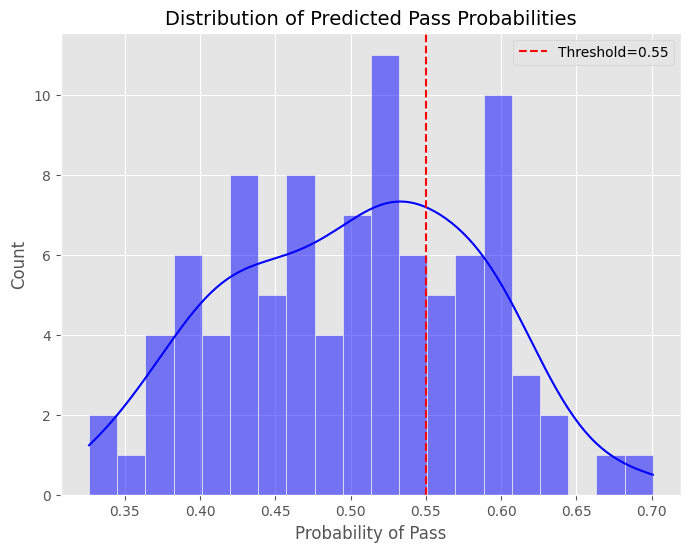

In [47]:
if grades is not None and attendances is not None and model is not None:
    # Prediction Probability Distribution
    plt.figure(figsize=(8, 6))
    sns.histplot(y_prob, bins=20, kde=True, color='blue')
    plt.axvline(x=threshold, color='red', linestyle='--', label=f'Threshold={threshold}')
    plt.title('Distribution of Predicted Pass Probabilities', fontsize=14)
    plt.xlabel('Probability of Pass', fontsize=12)
    plt.ylabel('Count', fontsize=12)
    plt.legend()
    plt.show()